In [47]:
#!pip install nibabel
#!pip install matplotlib
#!pip install opencv-python
#!pip install torch
#!pip install segmentation-models-3D
#!pip install classification-models-3D
#!pip install efficientnet-3D
#!pip install keras_applications
#!pip install scikit-image
#!pip install patchify

In [48]:
import numpy as np
import pandas as pd
import sys, os, glob
import math, random
import tensorflow as tf
from matplotlib import pyplot as plt
import random
import keras

print(tf.__version__)
print(keras.__version__)

import segmentation_models_3D as sm

sys.path.append('/path/to/2014_07_13_test')
import generate_input

2.9.0
2.9.0


In [49]:
import nibabel as nib
from matplotlib import pyplot as plt

import torch

import keras
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda, LeakyReLU
from keras.optimizers import Adam
from keras.metrics import MeanIoU

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

import segmentation_models_3D as sm


In [50]:
#!ls './preprocessed-data/images/'
#!ls './preprocessed-data/masks/'

In [51]:
#ct_nii = np.load('./preprocessed-data/masks/case_00011.npy')
#print(ct_nii.shape)
#print(np.unique(ct_nii))
#test = ct_nii[12,:,:]
#plt.imshow(test)

In [52]:
#ct_nii = nib.load('../kits21/kits21/data/case_00011/aggregated_AND_seg.nii.gz').get_fdata()
#print(ct_nii.shape)
#test = ct_nii[20,:,:]
#plt.imshow(test)
#print(np.unique(test))
#print(type(np.unique(test)[0]))

## Load data

In [53]:
def fill_3D_set(case_ids, image_dictionary, mask_dictionary):
    img_list, mask_list = [], []
    
    for idx, c in enumerate(case_ids):
        img_list.append(np.expand_dims(image_dictionary[c].T, axis=0).T)
        mask_list.append(np.expand_dims(mask_dictionary[c].T, axis=0).T)
        
        x_array, y_array = np.asarray(img_list).astype(np.float64), np.asarray(mask_list).astype(np.float64)
    
    return x_array, y_array

In [54]:
def crop_image_stack(img_dict, mask_dict, num_slices):
    
    for case_id in img_dict.keys():
        stack_size = img_dict[case_id].shape[0]
        bot_slice, top_slice = math.ceil((stack_size/2)-(num_slices/2)), math.ceil((stack_size/2)+(num_slices/2))
        #print(stack_size, bot_slice, top_slice)
        img_dict[case_id] = img_dict[case_id][bot_slice:top_slice, :, :]
        mask_dict[case_id] = mask_dict[case_id][bot_slice:top_slice, :, :]
        
    return img_dict, mask_dict

In [55]:
def resize_image_stack_and_flip(img_dict, mask_dict):
    
    for case_id in img_dict.keys():
    
        diff = img_dict[case_id].shape[1] - img_dict[case_id].shape[0]
        l, h = math.ceil(diff/2), math.floor(diff/2)

        if h==0:
            print('yo', case_id, img_dict[case_id].shape, mask_dict[case_id].shape)
            empty_array = np.zeros([img_dict[case_id].shape[1], img_dict[case_id].shape[2]])
            front_padding = np.array([empty_array]*l)
            resized_img = np.concatenate((front_padding, img_dict[case_id]))
            resized_mask = np.concatenate((front_padding, mask_dict[case_id]))
            
        elif img_dict[case_id].shape[0] < img_dict[case_id].shape[1]:
            #print('padding image stack from {0} to {1}'.format(img_dict[case_id].shape[0], img_dict[case_id].shape[1]))
            empty_array = np.zeros([img_dict[case_id].shape[1], img_dict[case_id].shape[2]])
            front_padding, back_padding = np.array([empty_array]*l), np.array([empty_array]*h)
            resized_img = np.concatenate((front_padding, img_dict[case_id]))
            resized_img = np.concatenate((resized_img,back_padding))
            resized_mask = np.concatenate((front_padding, mask_dict[case_id]))
            resized_mask = np.concatenate((resized_mask,back_padding))
        
        elif img_dict[case_id].shape[0] >= img_dict[case_id].shape[1]:
            resized_img = img_dict[case_id][-l:h].copy()
            resized_mask = mask_dict[case_id][-l:h].copy()

        img_dict[case_id] = resized_img
        mask_dict[case_id] = resized_mask
        #print('after padding:', img_dict[case_id].shape)
        #xz_slice = data[:, data.shape[1] // 2 - 1, :]
        #zx_slice = resized_img[:, :, resized_img.shape[-1] // 2 - 1]
        
    return img_dict, mask_dict

In [56]:
#ct_nii = nib.load('../kits21/kits21/data/case_00150/aggregated_MAJ_seg.nii.gz').get_fdata()
#print(ct_nii.shape)
#test = ct_nii[50,:,:]
#print(np.max(test))
#print(np.unique(test))
#plt.imshow(test)

In [57]:
#ct_nii = nib.load('../kits21/kits21/data/case_00200/aggregated_MAJ_seg.nii.gz').get_fdata()
#print(ct_nii.shape)
#test = ct_nii[40,:,:]
#print(np.max(test))
#print(np.unique(test))
#plt.imshow(test)

In [58]:
#ct_nii = nib.load('../kits21/kits21/data/case_00150/aggregated_MAJ_seg.nii.gz').get_fdata()
#print(ct_nii.shape)
#test = ct_nii[40,:,:]
#print(np.max(test))
#print(np.unique(test))
#plt.imshow(test)

# DATA PREPARATION

In [59]:
json_path = '../kits21/kits21/data/kits.json'
n_samples = 50
neg_pct = 100
rootdir = './preprocessed-data/'
img_dir = 'images'
mask_dir = 'masks'
val_split = 10
test_split = 10

#------------- Generate dictionary of case_id and binary malignant label --------
labels_dict = generate_input.malignant_labels_to_dict(json_path)
print('Number of labels in labels_dict: ', len(labels_dict))

#------------- Sample n instances from labels_dict with all possible negative cases --------
subsample_list = generate_input.generate_subsample_id_list(n_samples, neg_pct, labels_dict)

#------------- Generate list of paths to preprocessed images --------

image_paths_list = generate_input.processed_image_paths(rootdir, img_dir)
mask_paths_list = generate_input.processed_image_paths(rootdir, mask_dir)
print('Are image and mask path list the same lenght?: ', len(image_paths_list) == len(mask_paths_list))

#------------- Load images and masks filtered by subsample --------
image_dict = generate_input.load_nifti_img_and_mask_as_numpy(image_paths_list, subsample_list)
mask_dict = generate_input.load_nifti_img_and_mask_as_numpy(mask_paths_list, subsample_list)
print('Are image and mask dictionaries the same lenght?:', len(image_dict) == len(mask_dict))

#image_dict, mask_dict = crop_image_stack(image_dict, mask_dict, 20)

image_dict, mask_dict = resize_image_stack_and_flip(image_dict, mask_dict)
print('resized images and masks:', image_dict[subsample_list[0]].shape, mask_dict[subsample_list[0]].shape)

#--------------- flatten case and labels dictionary for split ---------------
cases = subsample_list
labels = [labels_dict[x] for x in cases]
print("Are cases and labels lists the same length?: ", len(cases) == len(labels), len(cases), len(labels))

#--------------- split training, validation and test set on patient/case level ---------------
id_train, labels_train, id_val, labels_val, id_test, labels_test = generate_input.split_sets(cases, labels, val_split, test_split)

x_train, mask_train = fill_3D_set(id_train, image_dict, mask_dict)
x_val, mask_val = fill_3D_set(id_val, image_dict, mask_dict)
x_test, mask_test = fill_3D_set(id_test, image_dict, mask_dict)
    
print("Are training set and labels lists the same length?: ", len(x_train) == len(mask_train), len(x_train), len(mask_train))
print("Are training imageas and masks same length?: ", len(mask_train) == len(x_train), len(mask_train), len(x_train))

Number of labels in labels_dict:  300
Generated list of 50 case IDs of 275 positive and 25 negative labels
Are image and mask path list the same lenght?:  True
Are image and mask dictionaries the same lenght?: True
resized images and masks: (128, 128, 128) (128, 128, 128)
Are cases and labels lists the same length?:  True 50 50
Generated training, validation and test with 30, 10 and 10 cases.
Are training set and labels lists the same length?:  True 30 30
Are training imageas and masks same length?:  True 30 30


In [60]:
print(type(x_train), x_train.shape, type(mask_train),  mask_train.shape, mask_train[0].shape)

<class 'numpy.ndarray'> (30, 128, 128, 128, 1) <class 'numpy.ndarray'> (30, 128, 128, 128, 1) (128, 128, 128, 1)


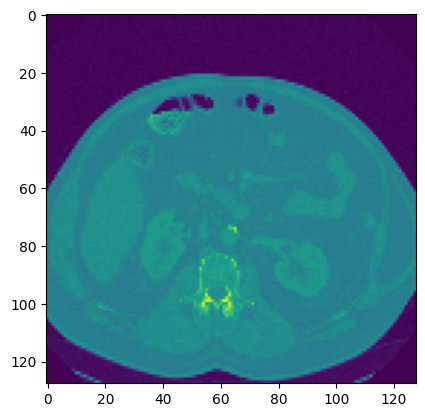

In [61]:
test = x_train[0][60,:,:]
plt.imshow(test)

[0. 1.]


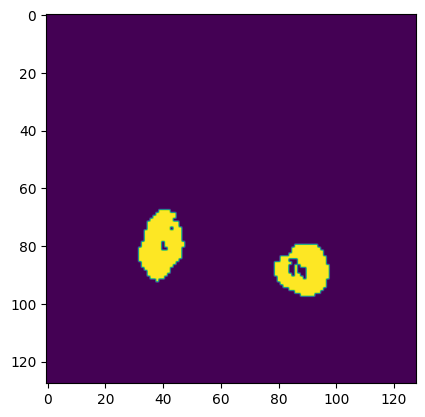

In [62]:
test = mask_train[0][60,:,:]
plt.imshow(test)
print(np.unique(test))

# Data generator

In [63]:
def imageLoader(img_list, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = img_list[batch_start:limit]
            Y = mask_list[batch_start:limit]

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size


In [64]:
print(mask_train.shape)

x_train, mask_train = torch.from_numpy(x_train), torch.from_numpy(mask_train[:,:,:,:,0].astype(int))
x_val, mask_val = torch.from_numpy(x_val), torch.from_numpy(mask_val[:,:,:,:,0].astype(int))
x_test, mask_test = torch.from_numpy(x_test), torch.from_numpy(mask_test[:,:,:,:,0].astype(int))

print(mask_train.shape)

#one hot encoding of index category masks to create binary channel for each class (background, kdiney, cyst, tumor) 
mask_train, mask_val, mask_test = torch.nn.functional.one_hot(mask_train), torch.nn.functional.one_hot(mask_val), torch.nn.functional.one_hot(mask_test)

print(mask_train.shape)

x_train, mask_train = tf.cast(x_train, tf.float32), tf.cast(mask_train, tf.float32)
x_val, mask_val = tf.cast(x_val, tf.float32), tf.cast(mask_val, tf.float32)
#mask_test = tf.cast(mask_test, tf.float32)

(30, 128, 128, 128, 1)
torch.Size([30, 128, 128, 128])
torch.Size([30, 128, 128, 128, 4])


In [65]:
batch_size = 5

train_img_datagen = imageLoader(x_train, mask_train, batch_size)
val_img_datagen = imageLoader(x_val, mask_val, batch_size)

#Verify generator
img, msk = train_img_datagen.__next__()
print(img.shape, msk.shape)

img_num = random.randint(0,(img.shape[0]-1))
test_img = img[img_num]
test_mask = msk[img_num]

n_slice = math.ceil(test_mask.shape[0]/2)
print(test_img.shape, img_num, n_slice)

torch.Size([5, 128, 128, 128, 1]) (5, 128, 128, 128, 4)
torch.Size([128, 128, 128, 1]) 3 64


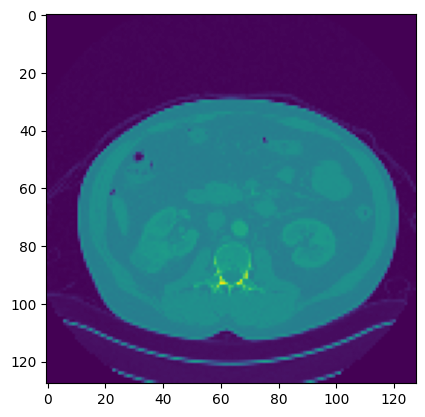

In [66]:
test = test_img[n_slice,:,:]
plt.imshow(test)

(128, 128, 4)
[0. 1.]


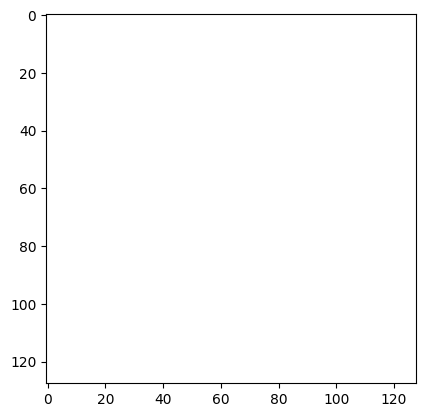

In [67]:
test = test_mask[n_slice,:,:]
print(test.shape)
plt.imshow(test)
print(np.unique(test_mask))

In [68]:
#xmsk,ymsk = mask_train[0], torch.from_numpy(np.random.randint(2, size=(128, 128, 128, 4)).astype(int))

#print(xmsk.shape, ymsk.shape)

In [69]:
#test = xmsk[64,:,:,1]
#print(test.shape)
#plt.imshow(test)
#print(np.unique(test_mask))

In [70]:
#test = ymsk[64,:,:,1]
#print(test.shape)
#plt.imshow(test)
#print(np.unique(test_mask))

In [71]:
#print(ymsk.shape, xmsk.shape)

'\nfrom keras import backend as K\n\ndef dice_coef(y_true, y_pred):\n    smooth = 0\n    y_true_f = K.flatten(y_true)\n    y_pred_f = K.flatten(y_pred)\n    intersection = K.sum(y_true_f * y_pred_f)\n    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)\n\ndef dice_coef_multilabel_total(y_true, y_pred, numLabels=4):\n    dice=0\n    for index in range(y_true.shape[3]):\n        subdice = dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])\n        dice -= dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])\n    return dice\n\ndef dice_coef_multilabel_individual(y_true, y_pred, numLabels=4):\n    dice_list = []\n    for index in range(y_true.shape[3]):\n        subdice = dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])\n        subdice = subdice.numpy()\n        print("subdice_indiv", subdice)\n        dice_list.append(subdice)\n    return dice_list\n    \n'

In [73]:
#a = dice_coef_multilabel_total(xmsk, ymsk)
#b = dice_coef_multilabel_individual(xmsk, ymsk)

In [74]:
#print(a)
#print(b)

# SEGMENTATION

## Defining Model

In [29]:
kernel_initializer =  'he_uniform'

################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = LeakyReLU(0.2)(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    c1 = LeakyReLU(0.2)(c1)
    
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = LeakyReLU(0.2)(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c2)
    c2 = LeakyReLU(0.2)(c2)
    
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = LeakyReLU(0.2)(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c3)
    c3 = LeakyReLU(0.2)(c3)
    
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = LeakyReLU(0.2)(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c4)
    c4 = LeakyReLU(0.2)(c4)
    
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = LeakyReLU(0.2)(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c5)
    c5 = LeakyReLU(0.2)(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = LeakyReLU(0.2)(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c6)
    c6 = LeakyReLU(0.2)(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = LeakyReLU(0.2)(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c7)
    c7 = LeakyReLU(0.2)(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = LeakyReLU(0.2)(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c8)
    c8 = LeakyReLU(0.2)(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = LeakyReLU(0.2)(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c9)
    c9 = LeakyReLU(0.2)(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

In [30]:
#Test if everything is working
model = simple_unet_model(128, 128, 128, 1, 4) #slices, height, width, channels, categories in mask
print(model.input_shape)
print(model.output_shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 1)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  448         ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

                                                                                                  
 dropout_4 (Dropout)            (None, 8, 8, 8, 256  0           ['leaky_re_lu_8[0][0]']          
                                )                                                                 
                                                                                                  
 conv3d_9 (Conv3D)              (None, 8, 8, 8, 256  1769728     ['dropout_4[0][0]']              
                                )                                                                 
                                                                                                  
 leaky_re_lu_9 (LeakyReLU)      (None, 8, 8, 8, 256  0           ['conv3d_9[0][0]']               
                                )                                                                 
                                                                                                  
 conv3d_tr

                                8, 16)                                                            
                                                                                                  
 dropout_8 (Dropout)            (None, 128, 128, 12  0           ['leaky_re_lu_16[0][0]']         
                                8, 16)                                                            
                                                                                                  
 conv3d_17 (Conv3D)             (None, 128, 128, 12  6928        ['dropout_8[0][0]']              
                                8, 16)                                                            
                                                                                                  
 leaky_re_lu_17 (LeakyReLU)     (None, 128, 128, 12  0           ['conv3d_17[0][0]']              
                                8, 16)                                                            
          

# Training

### Define loss and metrics

In [31]:
#Define loss, metrics and optimizer to be used for training
#wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
dice_loss = sm.losses.DiceLoss() #class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)] #, dice_coef_multilabel_individual]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

### Fit/train model

In [79]:
print(x_train.shape, mask_train.shape)
print(x_val.shape, mask_val.shape)

torch.Size([30, 128, 128, 128, 1]) (30, 128, 128, 128, 4)
torch.Size([10, 128, 128, 128, 1]) (10, 128, 128, 128, 4)


In [32]:
steps_per_epoch = len(x_train)//batch_size
val_steps_per_epoch = len(x_val)//batch_size

model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=1, 
                          num_classes=4)

model.compile(optimizer = optim, loss=dice_loss, metrics=metrics)
print(model.summary())
print(model.input_shape)
print(model.output_shape)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 1)]                                                           
                                                                                                  
 conv3d_19 (Conv3D)             (None, 128, 128, 12  448         ['input_2[0][0]']                
                                8, 16)                                                            
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)     (None, 128, 128, 12  0           ['conv3d_19[0][0]']              
                                8, 16)                                                      

                                                                                                  
 dropout_13 (Dropout)           (None, 8, 8, 8, 256  0           ['leaky_re_lu_26[0][0]']         
                                )                                                                 
                                                                                                  
 conv3d_28 (Conv3D)             (None, 8, 8, 8, 256  1769728     ['dropout_13[0][0]']             
                                )                                                                 
                                                                                                  
 leaky_re_lu_27 (LeakyReLU)     (None, 8, 8, 8, 256  0           ['conv3d_28[0][0]']              
                                )                                                                 
                                                                                                  
 conv3d_tr

                                8, 16)                                                            
                                                                                                  
 dropout_17 (Dropout)           (None, 128, 128, 12  0           ['leaky_re_lu_34[0][0]']         
                                8, 16)                                                            
                                                                                                  
 conv3d_36 (Conv3D)             (None, 128, 128, 12  6928        ['dropout_17[0][0]']             
                                8, 16)                                                            
                                                                                                  
 leaky_re_lu_35 (LeakyReLU)     (None, 128, 128, 12  0           ['conv3d_36[0][0]']              
                                8, 16)                                                            
          

 dropout_12 (Dropout)           (None, 16, 16, 16,   0           ['leaky_re_lu_24[0][0]']         
                                128)                                                              
                                                                                                  
 conv3d_26 (Conv3D)             (None, 16, 16, 16,   442496      ['dropout_12[0][0]']             
                                128)                                                              
                                                                                                  
 leaky_re_lu_25 (LeakyReLU)     (None, 16, 16, 16,   0           ['conv3d_26[0][0]']              
                                128)                                                              
                                                                                                  
 max_pooling3d_7 (MaxPooling3D)  (None, 8, 8, 8, 128  0          ['leaky_re_lu_25[0][0]']         
          

                                                                                                  
 conv3d_34 (Conv3D)             (None, 64, 64, 64,   27680       ['dropout_16[0][0]']             
                                32)                                                               
                                                                                                  
 leaky_re_lu_33 (LeakyReLU)     (None, 64, 64, 64,   0           ['conv3d_34[0][0]']              
                                32)                                                               
                                                                                                  
 conv3d_transpose_7 (Conv3DTran  (None, 128, 128, 12  4112       ['leaky_re_lu_33[0][0]']         
 spose)                         8, 16)                                                            
                                                                                                  
 concatena

In [33]:

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
callbacks=[callback]

#checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
#                             save_best_only=True, mode='min', save_weights_only = True)

#reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
#early = EarlyStopping(monitor="val_loss", 
#                      mode="min", 
#                      patience=10) # probably needs to be more patient, but kaggle time is limited
#callbacks_list = [checkpoint, early, reduceLROnPlat]

In [34]:
history=model.fit(train_img_datagen,
                  steps_per_epoch=steps_per_epoch,
                  epochs=20,
                  verbose=1,
                  validation_data=val_img_datagen,
                  validation_steps=val_steps_per_epoch,
                  callbacks=callbacks
                 )

Epoch 1/20


2023-05-01 10:56:15.396549: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-01 10:56:16.179106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.7584 - accuracy: 0.8986 - iou_score: 0.2274  

2023-05-01 11:08:51.337261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 772s 134s/step - loss: 0.7584 - accuracy: 0.8986 - iou_score: 0.2274 - val_loss: 0.7482 - val_accuracy: 0.9662 - val_iou_score: 0.2447
Epoch 2/20
6/6 [==============================] - 695s 116s/step - loss: 0.7449 - accuracy: 0.9679 - iou_score: 0.2467 - val_loss: 0.7441 - val_accuracy: 0.9740 - val_iou_score: 0.2482
Epoch 3/20
6/6 [==============================] - 645s 108s/step - loss: 0.7413 - accuracy: 0.9732 - iou_score: 0.2495 - val_loss: 0.7399 - val_accuracy: 0.9739 - val_iou_score: 0.2504
Epoch 4/20
6/6 [==============================] - 655s 110s/step - loss: 0.7362 - accuracy: 0.9769 - iou_score: 0.2529 - val_loss: 0.7368 - val_accuracy: 0.9776 - val_iou_score: 0.2527
Epoch 5/20
6/6 [==============================] - 655s 110s/step - loss: 0.7314 - accuracy: 0.9772 - iou_score: 0.2555 - val_loss: 0.7320 - val_accuracy: 0.9753 - val_iou_score: 0.2548
Epoch 6/20
6/6 [==============================] - 634s 106s/step - loss: 0.7248 - accu

In [40]:
print("number of epochs:", len(history.history['loss']))

number of epochs: 20


### Save model

In [41]:
model.save('lol8.hdf5')

## Loss

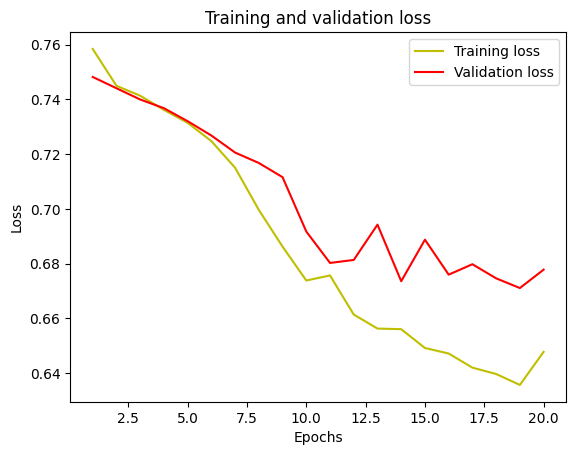

In [42]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']

val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

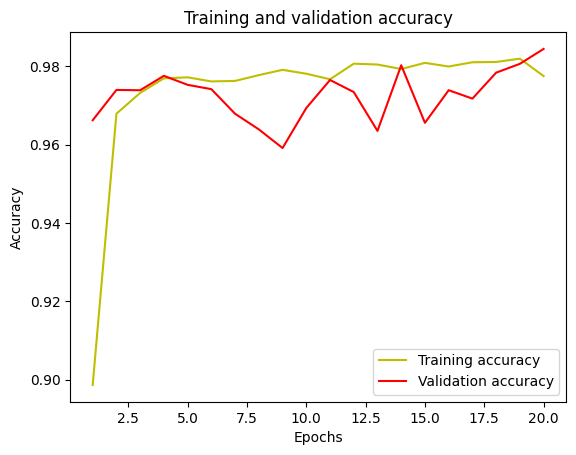

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Load trained model and continue training

In [44]:
#Load model for prediction or continue training
#my_model = load_model('lol3.hdf5', custom_objects={'dice_loss_plus_1focal_loss': total_loss, 
#                                                   'iou_score':sm.metrics.IOUScore(threshold=0.5)})

In [45]:
#Now all set to continue the training process. 
#history2=my_model.fit(train_img_datagen,
#          steps_per_epoch=steps_per_epoch,
#          epochs=1,
#         verbose=1,
#          validation_data=val_img_datagen,
#          validation_steps=val_steps_per_epoch,
#          )

## Predict masks

In [107]:
my_model = load_model('lol7.hdf5', 
                      compile=False)

x_test = tf.cast(x_test, tf.float64)

batch_size=10 #Check IoU for a batch of images
test_img_datagen = imageLoader(x_test, mask_test, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

print("test images shape:", test_image_batch.shape) 
print("test masks shape:", test_mask_batch.shape)

#predict masks
test_pred_batch = my_model.predict(test_image_batch)

test images shape: (10, 128, 128, 128, 1)
test masks shape: (10, 128, 128, 128, 4)


2023-05-02 08:40:09.042174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 20s 20s/step


In [108]:
#Calculating individual dice scores

from keras import backend as K

def dice_coef(y_true, y_pred):
    smooth = 0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel_total(y_true, y_pred, numLabels=4):
    dice=0
    for index in range(y_true.shape[3]):
        subdice = dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
        dice -= dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice

def dice_coef_multilabel_individual(y_true, y_pred, numLabels=4):
    dice_list = []
    for index in range(y_true.shape[3]):
        subdice = dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
        subdice = subdice.numpy()
        print("subdice_indiv", subdice)
        dice_list.append(subdice)
    return dice_list

In [111]:

for i in range(batch_size):
    indiv_dice_lst = dice_coef_multilabel_individual(test_mask_batch[i], test_pred_batch[i])
    
    print(indiv_dice_lst)


InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:Mul]

In [104]:
#Calculating mean IoU (related to dice)
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4) #one-hot to single channel image
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4) #one-hot to single channel image
print(test_mask_batch.shape, test_mask_batch_argmax.shape, np.unique(test_mask_batch), np.unique(test_mask_batch_argmax))
print(test_pred_batch.shape, test_pred_batch_argmax.shape, np.unique(test_pred_batch), np.unique(test_pred_batch_argmax))


#Verify IoU on a batch of images from the test dataset
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

(8, 128, 128, 128, 4) (8, 128, 128, 128) [0. 1.] [0 1 2 3]
(8, 128, 128, 128, 4) (8, 128, 128, 128) [0.0000000e+00 1.1755440e-38 1.1755626e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00] [0 1 2 3]
Mean IoU = 0.29049984


In [ ]:
#Predict on a few test images, one at a time
#Try images: 
img_num = id_test[5]

test_img = np.load("./preprocessed-data/images/"+str(img_num)+".npy")

test_mask = np.load("./preprocessed-data/masks/"+str(img_num)+".npy")
print(test_mask.shape)
#test_mask_argmax=np.argmax(test_mask, axis=3)

#test_img_input = np.expand_dims(test_img, axis=0)
#test_prediction = my_model.predict(test_img_input)
#test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))

In [ ]:


#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()